In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline

### Data Loading and Preprocessing

Training data has 346 rows (data samples) and 17 columns (16 input features, minus the first 'Outcome' column).

Next workings:
- Split the dataset into X_train and Y_train. 

- Scale data.

- Convert data into numpy array.

- LabelEncoder on y_train.

- Convert into pytorch tensors.

- Create DataLoader. (create a batch by extracting a slice from the dataset)

In [2]:
# Control randomness
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
train_df = pd.read_csv("Fetus_trainingdata.csv")
test_df = pd.read_csv("Fetus_testingdata.csv")

X_train = train_df.drop('Outcome', axis=1)
y_train = train_df['Outcome']

X_test = test_df.drop('Outcome', axis=1)
y_test = test_df['Outcome']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

- Datasets are highly mismatched. 
- This will lead to high overfitting problem going forward. 

Solution:

- Join both datasets into one file and use scikit test-train-split. 
- For this assignment, we skip this solution and will address the overfitting on the report.

### Preparing MLP

In [4]:
# Two layer neural network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(16, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 5)    # Changed 5 hidden units to 10 hidden units
        # self.softmax = nn.Softmax(dim=1)    # Applies across classes

    # Feedforward
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)    # raw logits
        # x = self.softmax(x)

        return logits

### Training the model

Binary Cross Entropy Loss

- y_pred: predicted probabilities, y_true: true labels (0 or 1)

- nn.CrossEntropyLoss expects raw logits → do not apply Softmax before it.

- During inference, if you want probabilities, then you can use torch.softmax(logits, dim=1).

- Model remains simpler and numerically stable.

In [15]:
def train(early_stopping=True):
    # Initialize model
    model = MyNet()

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Create an optimizer (Stochastic Gradient Descent - SGD)
    optimizer = optim.SGD(model.parameters(), lr=0.05)

    # Initialize learning rate scheduler 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-5)

    # Train the net
    epochs = 50
    # loss_per_iter = []
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    train_errors = []
    test_errors = []
    lrs = []

    patience = 10
    best_val_loss = float("inf") 
    patience_counter = 0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        num_errors_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            logits = model(X_batch)    # forward pass
            loss = criterion(logits, y_batch)      
            loss.backward()
            optimizer.step()

            # Save loss to plot
            train_loss += loss.item()
            # loss_per_iter.append(loss.item())

            # Compute training accuracy
            preds = torch.argmax(logits, dim=1)
            num_errors_train += (preds != y_batch).sum().item()
            total_train += y_batch.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * (1 - num_errors_train / total_train)


        # Validation
        model.eval()
        test_loss = 0.0
        num_errors_test = 0
        total_test = 0

        with torch.no_grad():
            for X_test, y_test in test_loader:
                logits = model(X_test)
                loss = criterion(logits, y_test)
                test_loss += loss.item()

                probs = torch.softmax(logits, dim=1)    # convert logits -> probabilities
                preds = torch.argmax(probs, dim=1)
                total_test += y_test.size(0)      # Keeping track how many samples have been processed
                num_errors_test += (preds != y_test).sum().item()     # Count misclassified
        
        avg_test_loss = test_loss / len(test_loader)
        test_acc = 100 * (1 - num_errors_test / total_test)

        scheduler.step(avg_test_loss)
        lrs.append(optimizer.param_groups[0]['lr'])

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        train_errors.append(num_errors_train)
        test_errors.append(num_errors_test)

        # Introducing early stopping
        if avg_test_loss < best_val_loss:
            best_val_loss = avg_test_loss
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if early_stopping and patience_counter >= patience:
                print(f"Early stopping at epoch {best_epoch + 1}")
                break

        print(f"Epoch [{epoch+1}/{epochs}] "
            f"Training Loss: {avg_train_loss:.4f} | "
            f"Training Accuracy: {train_acc:.2f}% | "
            f"Testing Loss: {avg_test_loss:.4f} | "
            f"Testing Accuracy: {test_acc:.2f}%")
        
    return train_losses, test_losses, best_epoch, train_accuracy, test_accuracy, lrs 


In [16]:
train_losses, test_losses, best_epoch, train_accuracy, test_accuracy, lrs = train()

Epoch [1/50] Training Loss: 1.7366 | Training Accuracy: 4.62% | Testing Loss: 1.5474 | Testing Accuracy: 31.03%
Epoch [2/50] Training Loss: 1.4509 | Training Accuracy: 47.69% | Testing Loss: 1.3168 | Testing Accuracy: 62.07%
Epoch [3/50] Training Loss: 1.2523 | Training Accuracy: 61.85% | Testing Loss: 1.1530 | Testing Accuracy: 62.07%
Epoch [4/50] Training Loss: 1.1063 | Training Accuracy: 61.27% | Testing Loss: 1.0346 | Testing Accuracy: 65.52%
Epoch [5/50] Training Loss: 0.9991 | Training Accuracy: 63.58% | Testing Loss: 0.9489 | Testing Accuracy: 65.52%
Epoch [6/50] Training Loss: 0.9183 | Training Accuracy: 65.32% | Testing Loss: 0.8824 | Testing Accuracy: 65.52%
Epoch [7/50] Training Loss: 0.8562 | Training Accuracy: 63.58% | Testing Loss: 0.8276 | Testing Accuracy: 65.52%
Epoch [8/50] Training Loss: 0.8085 | Training Accuracy: 65.61% | Testing Loss: 0.7857 | Testing Accuracy: 63.79%
Epoch [9/50] Training Loss: 0.7745 | Training Accuracy: 65.32% | Testing Loss: 0.7578 | Testing A

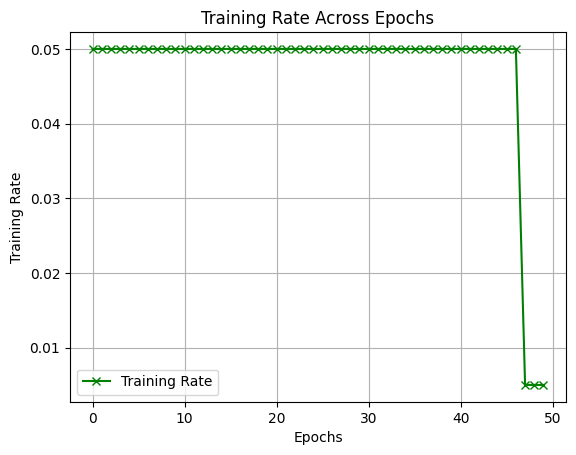

In [17]:
# Plotting learning rate across epochs
plt.plot(lrs, label='Training Rate', marker='x', color='green')
plt.xlabel('Epochs')
plt.ylabel("Training Rate")
plt.title('Training Rate Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

### Loss/Accuracy plots to check convergence and overfitting trends

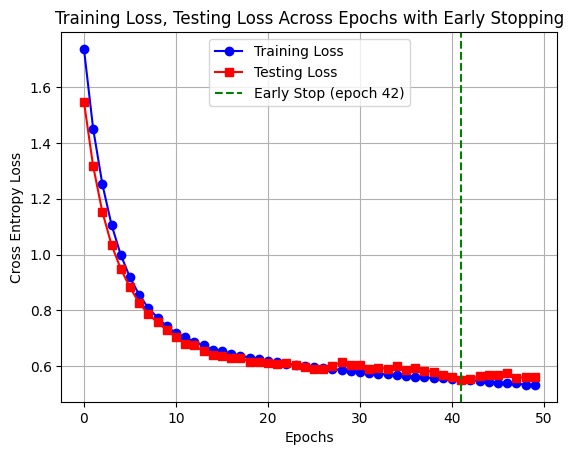

In [18]:
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(test_losses, label='Testing Loss', marker='s', color='red')
plt.axvline(best_epoch, color='green', linestyle='--', label=f'Early Stop (epoch {best_epoch+1})')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss, Testing Loss Across Epochs with Early Stopping')
plt.grid(True)
plt.legend()
plt.show()

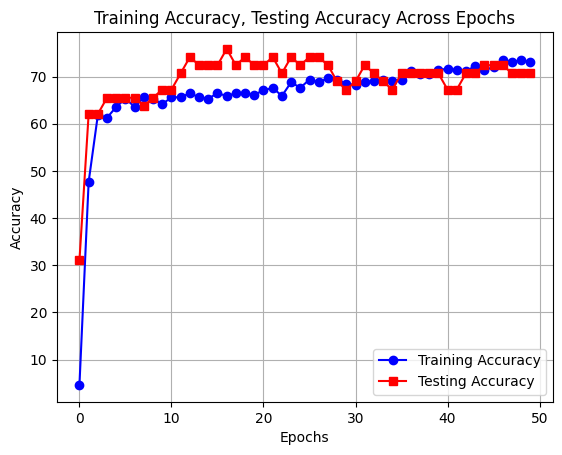

In [19]:
plt.plot(train_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(test_accuracy, label='Testing Accuracy', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy, Testing Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

Findings:

- Based on the Loss plot, we can see that the learning curve is parallel and stable. This means that the model is a good fit.

Next workings:

- Analyze model fit and bias-variance tradeoff
- Introduces regularization. (To prevent overfitting)
- Get the best hyperparameters, parameters


**Hyperparameters Grid Search**

In [20]:
# Hyperparameters experiment
# Model definition for varying layers
class Net_VaryLayers(nn.Module):
    def __init__(self, activation_fn=nn.ReLU, num_layers=2, dropout_rate = 0.3, use_batchnorm=False):
        super(Net_VaryLayers, self).__init__()
        layers = []
        input_dim = X_train.shape[1]
        hidden_dim = 10     

        # Activation map (string name to class)
        if isinstance(activation_fn, str):
            activation_map = {
                'ReLU': nn.ReLU,
                'Tanh': nn.Tanh,
            }
            activation_fn = activation_map.get[activation_fn, nn.ReLU]
        
        # Build hidden layer
        for i in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim

        # Final layer to 5 output classes    
        layers.append(nn.Linear(input_dim, 5))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.network(x)
        return logits

In [38]:
# Finding best hyperparameters
def train_model(config, train_loader, test_loader, epochs=50, patience=10, early_stopping=True):
    
    if isinstance(config["loss_fn"], str):
            loss_fn_map = {
                'CrossEntropyLoss': nn.CrossEntropyLoss,
                'MSELoss': nn.MSELoss
            }
            config["loss_fn"] = loss_fn_map[config["loss_fn"]]
    
    model = Net_VaryLayers(
        num_layers=config["num_layers"],
        activation_fn=config["activation"],
        dropout_rate=config["dropout_rate"],
        use_batchnorm=True,
    )

    if config["optimizer"] == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=config["lr"],
                               weight_decay=config["weight_decay"])
    elif config["optimizer"] == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                            lr=config["lr"],
                            weight_decay=config["weight_decay"])
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-5)
    
    criterion = config["loss_fn"]()

    # Variables for plotting
    training_losses, testing_losses = [], []
    training_accuracy, testing_accuracy = [], []

    # Early stopping parameters
    best_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    # initial_dropout = config["dropout_rate"]

    for epoch in range(epochs):
        model.train()
        total_training_loss, training_error, total_training = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)

            if isinstance(criterion, nn.MSELoss):
                y_onehot = nn.functional.one_hot(y_batch, num_classes=5).float()
                loss = criterion(torch.softmax(logits, dim=1), y_onehot)
            else:
                loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()

            total_training_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            training_error += (preds != y_batch).sum().item()
            total_training += y_batch.size(0)

        avg_training_loss = round(total_training_loss / len(train_loader), 4)
        training_accuracies = round(100 * (1 - training_error / total_training), 2)

        model.eval()
        total_testing_loss, testing_error, total_testing = 0, 0, 0

        with torch.no_grad():
            for X_test, y_test in test_loader:
                logits = model(X_test)

                if isinstance(criterion, nn.MSELoss):
                    y_onehot = nn.functional.one_hot(y_test, num_classes=5).float()
                    loss = criterion(torch.softmax(logits, dim=1), y_onehot)
                else:
                    loss = criterion(logits, y_test)

                total_testing_loss += loss.item()    
                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                testing_error += (preds != y_test).sum().item()
                total_testing += y_test.size(0)

        avg_testing_loss = round(total_testing_loss / len(test_loader), 4)
        testing_accuracies = round(100 * (1 - testing_error / total_testing), 2)

        scheduler.step(avg_testing_loss)

        training_losses.append(avg_training_loss)
        testing_losses.append(avg_testing_loss)
        training_accuracy.append(training_accuracies)
        testing_accuracy.append(testing_accuracies)

        print(f"Epoch [{epoch+1}/{epochs}] "
            f"Training Loss: {avg_training_loss:.4f} | Training Accuracy: {training_accuracies:.2f}% | "
            f"Testing Loss: {avg_testing_loss:.4f} | Testing Accuracy: {testing_accuracies:.2f}% ")

        # Early stopping
        if early_stopping:
            if avg_testing_loss < best_loss:
                best_loss = avg_testing_loss
                best_epoch = epoch 
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    if best_model_state:
                        model.load_state_dict(best_model_state)
                    break

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        "training_losses": training_losses,
        "testing_losses": testing_losses,
        "training_accuracy": training_accuracy,
        "testing_accuracy": testing_accuracy,
        "final_training_accuracy": training_accuracy[-1],
        "final_testing_accuracy": testing_accuracy[-1],
        "final_training_loss": training_losses[-1],
        "final_testing_loss": testing_losses[-1],
        "num_params": num_params,
        "best_epoch": best_epoch,
        "best_lr": config["lr"],
        "model": model
    }

In [39]:
param_grid = {
    "lr": [0.001, 0.01, 0.05],    # tune lr for loss 
    "num_layers": [2, 3],       # model complexity
    "activation": [nn.ReLU, nn.Tanh],
    "loss_fn": [nn.CrossEntropyLoss, nn.MSELoss],   # CrossEntropyLoss: best suited for classification
    "weight_decay": [0.0001, 0.005],      
    "dropout_rate": [0.3, 0.4],      # tune for generalization & overfitting
    "optimizer": ['SGD', 'Adam']
}

configs = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
print(f"Total unique configs: {len(configs)}")

Total unique configs: 192


In [40]:
results = []

for i, cfg in enumerate(configs):
    print(f"\nRunning configuration {i+1}/{len(configs)}: {cfg}")
    metrics = train_model(cfg, train_loader, test_loader, epochs=50, patience=10, early_stopping=True)
    metrics.update(cfg)
    results.append({
        "num_layers": cfg["num_layers"],
        "lr": cfg["lr"],
        "optimizer": cfg["optimizer"],
        "activation": cfg["activation"].__name__,
        "loss_fn": cfg["loss_fn"].__name__,
        "weight_decay": cfg["weight_decay"],
        "dropout_rate": cfg["dropout_rate"],
        "train_acc": metrics["final_training_accuracy"],
        "test_acc": metrics["final_testing_accuracy"],
        "params": metrics["num_params"],
        "best_epoch": metrics["best_epoch"],
        "model": metrics["model"]
    })


Running configuration 1/192: {'lr': 0.001, 'num_layers': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'loss_fn': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'weight_decay': 0.0001, 'dropout_rate': 0.3, 'optimizer': 'SGD'}
Epoch [1/50] Training Loss: 1.8989 | Training Accuracy: 5.49% | Testing Loss: 1.9523 | Testing Accuracy: 0.00% 
Epoch [2/50] Training Loss: 1.8996 | Training Accuracy: 6.65% | Testing Loss: 1.9736 | Testing Accuracy: 0.00% 
Epoch [3/50] Training Loss: 1.8580 | Training Accuracy: 8.38% | Testing Loss: 1.9665 | Testing Accuracy: 0.00% 
Epoch [4/50] Training Loss: 1.8378 | Training Accuracy: 10.12% | Testing Loss: 1.9648 | Testing Accuracy: 1.72% 
Epoch [5/50] Training Loss: 1.8190 | Training Accuracy: 9.54% | Testing Loss: 1.9434 | Testing Accuracy: 1.72% 
Epoch [6/50] Training Loss: 1.8163 | Training Accuracy: 9.54% | Testing Loss: 1.9394 | Testing Accuracy: 1.72% 
Epoch [7/50] Training Loss: 1.8243 | Training Accuracy: 10.98% | Testing Loss: 1.9

In [41]:
results_df = pd.DataFrame(results)
results_df.sort_values("test_acc", ascending=False).head(10)

,num_layers,lr,optimizer,activation,loss_fn,weight_decay,dropout_rate,train_acc,test_acc,params,best_epoch,model
190,3,0.050,SGD,Tanh,MSELoss,0.0050,0.4,63.87,84.48,375,49,Net_VaryLayers(\n (network): Sequential(\n ...
84,2,0.010,SGD,Tanh,CrossEntropyLoss,0.0050,0.3,64.45,81.03,245,49,Net_VaryLayers(\n (network): Sequential(\n ...
152,2,0.050,SGD,Tanh,MSELoss,0.0001,0.3,66.18,81.03,245,49,Net_VaryLayers(\n (network): Sequential(\n ...
177,3,0.050,Adam,Tanh,CrossEntropyLoss,0.0001,0.3,64.74,81.03,375,6,Net_VaryLayers(\n (network): Sequential(\n ...
51,3,0.001,Adam,Tanh,CrossEntropyLoss,0.0001,0.4,65.32,79.31,375,49,Net_VaryLayers(\n (network): Sequential(\n ...
89,2,0.010,Adam,Tanh,MSELoss,0.0001,0.3,66.76,79.31,245,4,Net_VaryLayers(\n (network): Sequential(\n ...
47,3,0.001,Adam,ReLU,MSELoss,0.0050,0.4,63.87,79.31,375,48,Net_VaryLayers(\n (network): Sequential(\n ...
99,3,0.010,Adam,ReLU,CrossEntropyLoss,0.0001,0.4,68.79,79.31,375,16,Net_VaryLayers(\n (network): Sequential(\n ...
135,2,0.050,Adam,ReLU,CrossEntropyLoss,0.0050,0.4,68.50,79.31,245,17,Net_VaryLayers(\n (network): Sequential(\n ...
83,2,0.010,Adam,Tanh,CrossEntropyLoss,0.0001,0.4,63.87,77.59,245,11,Net_VaryLayers(\n (network): Sequential(\n ...


- Low loss when using MSELoss is misleading since this function is not ideal for classification task. 
- MSELoss yields lower absolute number that falls quickly but doesn't maximize confidence.
- Lets stick with CrossEntropyLoss

In [42]:
best = results_df.sort_values("test_acc", ascending=False).iloc[0]
print("\nBest Hyperparameters from Param Grid")
best


Best Hyperparameters from Param Grid


num_layers                                                      3
lr                                                           0.05
optimizer                                                     SGD
activation                                                   Tanh
loss_fn                                                   MSELoss
weight_decay                                                0.005
dropout_rate                                                  0.4
train_acc                                                   63.87
test_acc                                                    84.48
params                                                        375
best_epoch                                                     49
model           Net_VaryLayers(\n  (network): Sequential(\n   ...
Name: 190, dtype: object

### Optimized Model

- From parameters grid search, tweak the values to better tune the models.
- 'nn.Tanh' as the activation function in the hidden layers might be clipping the gradients early, leading to slower convergence and preventing the final layer from outputting extreme, confident probabilities.
- High loss problem... Should introduce Adam in config to compare both optimizer
- Lower LR requires more epochs. My laptop is heating send help 🥲

In [43]:
best_cfg = best.to_dict()
best_epoch = best_cfg['best_epoch']

activation_map = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh}
loss_fn_map = {'CrossEntropyLoss': nn.CrossEntropyLoss, 'MSELoss': nn.MSELoss}
best_cfg['activation'] = activation_map[best_cfg['activation']]
best_cfg['loss_fn'] = loss_fn_map[best_cfg['loss_fn']]

In [44]:
# Apply final param configuration to ensure optimization.
if best_cfg['loss_fn'] == nn.MSELoss or best_cfg['activation'] == nn.Tanh:
    print(f"\nBest model used loss_fn={best_cfg['loss_fn'].__name__}. Switching for CrossEntropyLoss for final training to ensure confident loss.")
    best_cfg['loss_fn'] = nn.CrossEntropyLoss
    print(f"\nBest model used activation={best_cfg['activation'].__name__}. Switching for ReLU for final training to prevent gradient saturation.")
    best_cfg['activation'] = nn.ReLU


Best model used loss_fn=MSELoss. Switching for CrossEntropyLoss for final training to ensure confident loss.

Best model used activation=Tanh. Switching for ReLU for final training to prevent gradient saturation.


In [45]:
optimized_model = train_model(best_cfg, train_loader, test_loader, epochs=best_epoch + 1, patience=10, early_stopping=True)

Epoch [1/50] Training Loss: 1.5250 | Training Accuracy: 26.88% | Testing Loss: 1.4462 | Testing Accuracy: 41.38% 
Epoch [2/50] Training Loss: 1.2774 | Training Accuracy: 44.51% | Testing Loss: 1.2522 | Testing Accuracy: 44.83% 
Epoch [3/50] Training Loss: 1.1263 | Training Accuracy: 49.42% | Testing Loss: 1.1168 | Testing Accuracy: 53.45% 
Epoch [4/50] Training Loss: 1.0214 | Training Accuracy: 52.60% | Testing Loss: 1.0332 | Testing Accuracy: 53.45% 
Epoch [5/50] Training Loss: 0.9649 | Training Accuracy: 47.40% | Testing Loss: 0.9751 | Testing Accuracy: 55.17% 
Epoch [6/50] Training Loss: 0.9172 | Training Accuracy: 52.31% | Testing Loss: 0.9351 | Testing Accuracy: 55.17% 
Epoch [7/50] Training Loss: 0.8776 | Training Accuracy: 51.45% | Testing Loss: 0.9033 | Testing Accuracy: 55.17% 
Epoch [8/50] Training Loss: 0.8460 | Training Accuracy: 52.31% | Testing Loss: 0.8690 | Testing Accuracy: 63.79% 
Epoch [9/50] Training Loss: 0.8112 | Training Accuracy: 56.07% | Testing Loss: 0.8446 | 

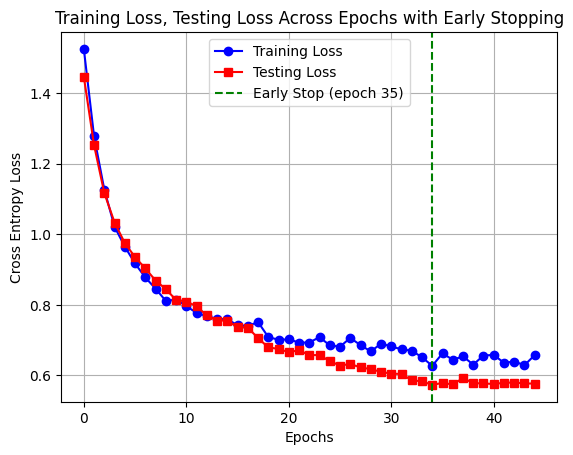

In [46]:
training_losses = optimized_model["training_losses"]
testing_losses = optimized_model["testing_losses"]
training_accuracy = optimized_model["training_accuracy"]
testing_accuracy = optimized_model["testing_accuracy"]
best_epoch = optimized_model["best_epoch"]

plt.plot(training_losses, label='Training Loss', marker='o', color='blue')
plt.plot(testing_losses, label='Testing Loss', marker='s', color='red')
plt.axvline(best_epoch, color='green', linestyle='--', label=f'Early Stop (epoch {best_epoch+1})')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss, Testing Loss Across Epochs with Early Stopping')
plt.grid(True)
plt.legend()
plt.show()

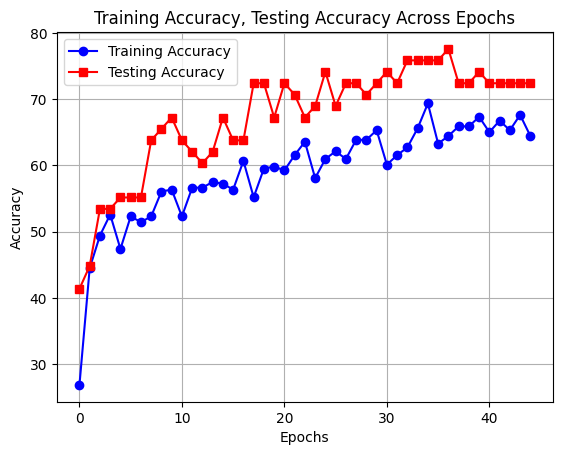

In [47]:
plt.plot(training_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(testing_accuracy, label='Testing Accuracy', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy, Testing Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()